In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sparse
import scipy.stats as stats
import seaborn as sns
import moveSTIR as stir
import importlib 
from matplotlib.colors import TwoSlopeNorm

# Set plot properties
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"

# Workflow for basic MoveSTIR analysis

The following steps illustrate the most basic MoveSTIR analysis. More detailed examples are given in `moveSTIR_examples.ipynb` and `movestir_pig_movements.ipynb`.

1. Obtain continuous-time estimates of host movements trajectories
2. Choose MoveSTIR parameters
3. Calculate pairwise transmission kernels
4. Explore transmission kernels
5. Explore prospective disease dynamics through $R_0$ analysis

## Step 1: Obtain continuous-time estimates of host movement trajectories

The theory for fitting continuous-time movement models to GPS data is well-described elsewhere (e.g., Hooten et al. 2017, *Animal Movement* and Calabrese et al. 2016, *Methods in Ecology and Evolution*) .  Here we simulate continuous time movement trajectories using a Functional Movement Model (Hooten and Johnson 2017, *JASA*).  We use these simulations as our example trajectories.

In [2]:
# FMM parameters
n = 100 # Number of observed points
m = 850 # Number of points at which to approximate the integral. See Hooten and Johnson 2017
σ_measure = 0 # No measurement error
σ_process = .1 # White noise variability
deltat = 1  
ϕ_H = 0.01 # As sigma H goes to zero, you get Brownian motion

nvals = stir.set_discretized_values(0, 1, n)['y'] 

# Set random seed for reproducibility
rint = 13
np.random.seed(rint)
for i in range(5):
    # Simulate and save movement trajectories
    sim = stir.simulate_movement(nvals, m, σ_process, σ_measure, ϕ_H, init_position=np.array([0, 0]))
    sim.to_csv("host{0}_example_n={1}_example.csv".format(i + 1, n), index=False)

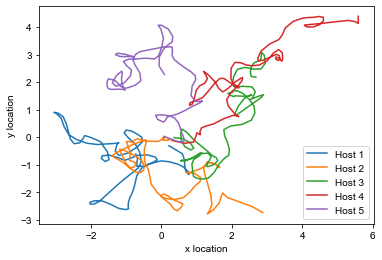

In [3]:
# Load and plot trajectories
num = 100
host_trajs = {'h{0}'.format(i + 1): pd.read_csv("host{0}_example_n={1}_example.csv".format(i + 1, num)) 
              for i in [0, 1, 2, 3, 4]}
host_keys = list(host_trajs.keys())
deltat = host_trajs[host_keys[0]].time.values[1] - host_trajs[host_keys[0]].time.values[0]
for i in range(5):
    plt.plot(host_trajs['h{0}'.format(i + 1)].x, host_trajs['h{0}'.format(i + 1)].y, '-', label="Host {0}".format(i + 1))
plt.xlabel("x location")
plt.ylabel("y location")
plt.legend(prop={'size': 10})

## Step 2: Define the parameters of MoveSTIR 

There are four key MoveSTIR parameters/functions in the basic formulation presented in the main text

1. Pathogen decay rate $\nu$
2. The contact function $\Phi(\cdot)$ and its associated parameter
    - Following Gurarie & Ovaskainen 2013 (Theoretical Ecology), one might consider a "top-hat" contact function or a Gaussian contact function
3. The acquisition rate $\tilde{\beta}$
4. The deposition rate $\lambda$

In the basic formulation of MoveSTIR $\tilde{\beta}$ and $\lambda$ act as scalars so their exact values don't matter for *relative* infection risk.

In [4]:
β = 1 # acquisition area / time
λ = 1 # deposition per time
ν = 1 # Pathogen decay per time
α = 0.1 # For top-hat contact function, hosts outside of 0.1 units distance don't experience contact

## Step 3:  Calculate pairwise transmission kernels

First, we demonstrate how to calculate the pairwise transmission kernel $K_{i \leftarrow j}$ from two host trajectories. The pairwise 

In [5]:
h1 = host_trajs['h1']
h2 = host_trajs['h2']

# Cutoff represents the top-hat contact function
deltat, K_1from2, Dmat = stir.transmission_kernel(h1, h2, ν, α, dd_type="cutoff")

Because $\tilde{\beta}$ and $\lambda$ are scalars they are simply multipliers on the transmission kernel and are not passed in.  The output is the time step $\Delta t$, transmission matrix (i.e., a discretized form of the transmission kernel), and the time-dependent distance matrix.

The transmission matrix itself can be viewed, where colored points give you the weight of a contact. Purple indicates no contact.

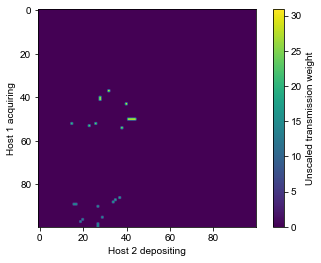

In [6]:
plt.imshow(K_1from2)
plt.xlabel("Host 2 depositing")
plt.ylabel("Host 1 acquiring")
cbar = plt.colorbar()
cbar.set_label("Unscaled transmission weight")

We can also view marginals to understand time varying force of infection 

Text(0, 0.5, 'Force of infection from 2 to 1 (time$^{-1}$)')

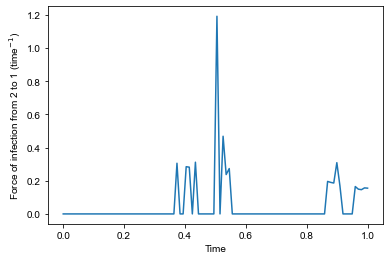

In [7]:
# Multiply by deltat because we are integrating the transmission kernel
# to calculate force of infection
foi_1from2 = K_1from2.sum(axis=1) * deltat * β * λ
plt.plot(h1.time, foi_1from2)
plt.xlabel("Time")
plt.ylabel("Force of infection from 2 to 1 (time$^{-1}$)")

For large transmission kernels, we can use another function that will directly calculate force of infection to avoid having to save the transmission kernel.  This can be substantially faster.

In [8]:
deltat, fois, _ = stir.transmission_kernel_summarize(h1, h2, ν, α, dd_type="cutoff", 
                                                     with_params_dt=True, beta=β, lam=λ)
direct_foi = fois[0]
indirect_foi = fois[1]

Text(0, 0.5, 'Force of infection from 2 to 1 (time$^{-1}$)')

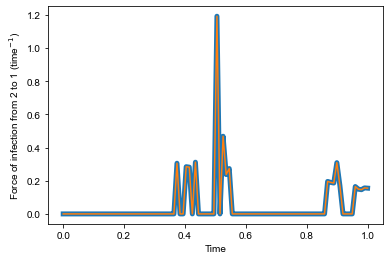

In [9]:
plt.plot(h1.time, direct_foi + indirect_foi, lw=5)
plt.plot(h1.time, foi_1from2)
plt.xlabel("Time")
plt.ylabel("Force of infection from 2 to 1 (time$^{-1}$)")

We get the same results using either approach

---

Now we can calculate all of the transmission kernels and look at FOI patterns

## Step 4: Explore transmission kernels

Now we might want to calculate potential FOI experienced for each individual

In [10]:
import itertools

# Calculate all FOI trajectories
host_fois = np.empty((len(host_keys), len(h1.time)))

# Loop through acquiring hosts
for j, hi in enumerate(host_keys):
    
    # Loop through depositing hosts
    tfois = []
    for hj in host_keys:
        
        if hi != hj:
            deltat, fois, _ = stir.transmission_kernel_summarize(host_trajs[hi], host_trajs[hj], ν, α, dd_type="cutoff", 
                                                                 with_params_dt=True, beta=β, lam=λ)
            tfois.append(fois[0] + fois[1])
    
    host_fois[j, :] = np.array(tfois).sum(axis=0)

Make a plot of cumulative FOI trajectories for each individual

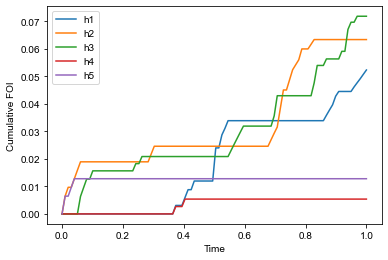

In [11]:
for i, h in enumerate(host_keys):
    plt.plot(h1.time, np.cumsum(host_fois[i, :]*deltat), label=h)
plt.xlabel("Time")
plt.ylabel("Cumulative FOI")
plt.legend()

## Step 5: Explore prospective disease dynamics through $R_0$ analysis

We can use MoveSTIR to explore the epidemiological implications of movement. The parameter $\gamma$ is recovery rate in an Susceptible-Infected-Susceptible model.

In [15]:
params = {'pathogen_decay': ν,
          'distance_decay': α,
          'beta': β,
          'lambda': λ,
          'gamma': 0.01, 
          'dd_type': "cutoff"}

# Given an SIS model formulation and completely arbitrary
# choices for our rate parameters,
# how do movement patterns translate into R0?
R, R0, F, U = stir.movement_R0(host_trajs, params)

In [16]:
R0

3.717841581163476

Based on the arbitrary parameter choices, $R_0 > 1$ indicates the pathogen can invade the dynamic movement network.

See `moveSTIR_examples.ipynb` for additional examples and analysis